In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

# Problem 1

In [2]:
S0 = 50
r = 0.02
T = 0.5
sigma = 0.25
K = 55
M = 100

U1 = np.random.uniform(0, 1, 10)*0.4
U2 = np.random.uniform(0, 1, 30)*0.2 + 0.4
U3 = np.random.uniform(0, 1, 30)*0.2 + 0.6
U4 = np.random.uniform(0, 1, 30)*0.2 + 0.8

S = np.zeros(M)
payoff = np.zeros(M)

for i in range((int)((3*M)/10)):
    S[(int)((i/3)*(1-i%3))] = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*stats.norm.ppf(U1[(int)((i/3)*(1-i%3))]))
    payoff[(int)((i/3)*(1-i%3))] = np.exp(-r*T)*max(S[(int)((i/3)*(1-i%3))]-K, 0)
    
    S[i+10] = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*stats.norm.ppf(U2[i]))
    payoff[i+10] = np.exp(-r*T)*max(S[i+10]-K, 0)
    
    S[i+40] = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*stats.norm.ppf(U3[i]))
    payoff[i+40] = np.exp(-r*T)*max(S[i+40]-K, 0)
    
    S[i+70] = S0*np.exp((r-sigma**2/2)*T + sigma*np.sqrt(T)*stats.norm.ppf(U4[i]))
    payoff[i+70] = np.exp(-r*T)*max(S[i+70]-K, 0)
    
mu1 = np.average(payoff[0:9])
mu2 = np.average(payoff[10:39])
mu3 = np.average(payoff[40:69])
mu4 = np.average(payoff[70:99])

sig1 = np.std(payoff[0:9])
sig2 = np.std(payoff[10:39])
sig3 = np.std(payoff[40:69])
sig4 = np.std(payoff[70:99])

price = 0.4*mu1+0.2*(mu2+mu3+mu4)
std_err = np.sqrt((0.4*sig1**2+0.2*(sig2**2+sig3**2+sig4**2))/M)

print("The estimated value of the price of the option is: " + str(price))
print("The estimated standard error of the price of the option is: " + str(std_err))

The estimated value of the price of the option is: 1.827972901022458
The estimated standard error of the price of the option is: 0.30889960486223494


# Problem 2

In [3]:
def sim_claims(M):
    cost = np.zeros(M)
    loss = np.zeros(M)
    zero_count = 0
    count1000 = 0
    
    for i in range(M):
        N = np.random.binomial(12, 0.4)
        prob = np.random.random(N)
        
        claims = [np.random.gamma(5, 100)*(prob[i]<0.25)+np.random.gamma(4, 50)*(prob[i]>=0.25) for i in range(N)]
        loss[i] = np.sum(claims)
        
        if(loss[i]<1000):
            cost[i] = 0
        elif(1000<=loss[i]<2500):
            cost[i] = 0.5*(loss[i]-1000)
        else:
            cost[i] = loss[i]-1750
        
        if(cost[i] == 0):
            zero_count += 1
        elif(cost[i] >= 1000):
            count1000 += 1
    
    prob0 = zero_count/M
    prob1000 = count1000/M
    expectation = np.sum(cost)/M
    return [prob0, expectation, prob1000]

M = 10000
results = sim_claims(M)
print("For " + str(M) + " simulations, the probability that the insurance company pays nothing is: " + str(results[0])
        + ", the expected cost to the insurance company is: " + str(results[1]) + ", and the probability that the "
     "insurer will have to pay more than $1000 is: " + str(results[2]))

For 10000 simulations, the probability that the insurance company pays nothing is: 0.3305, the expected cost to the insurance company is: 222.6892978105333, and the probability that the insurer will have to pay more than $1000 is: 0.0226


# Problem 3

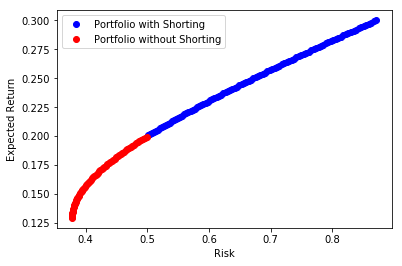

In [52]:
# Part 1
mu = [0.1, 0.2]
C = np.array([[0.16, 0.1], [0.1, 0.25]])

w1 = np.linspace(-1, 2, 300)
w2 = 1-w1
w = np.transpose(np.array([w1, w2]))
muV = []
volatilities = []
short_indices = []
long_indices = []

for i in range(np.size(w, axis=0)):
    muV.append(np.linalg.multi_dot([w[i], np.transpose(mu)]))
    volatilities.append(np.sqrt(np.linalg.multi_dot([w[i], C, np.transpose(w[i])])))
    if(w[i, 0]<0 or w[i, 1]<0):
        short_indices.append(i)
    else:
        long_indices.append(i)

muV_short = np.array([muV[i] for i in short_indices])
vol_short = np.array([volatilities[i] for i in short_indices])
muV_long = np.array([muV[i] for i in long_indices])
vol_long = np.array([volatilities[i] for i in long_indices])

w_min = np.linalg.multi_dot([np.transpose(np.ones(np.size(C, axis=0))), np.linalg.inv(C)])
w_min = w_min/np.linalg.multi_dot([np.transpose(np.ones(np.size(C, axis=0))), np.linalg.inv(C), np.ones(np.size(C, axis=0))])

mu_min_port = np.linalg.multi_dot([w_min, np.transpose(mu)])

plt.plot(vol_short[muV_short>mu_min_port], muV_short[muV_short>mu_min_port], 'bo')
plt.plot(vol_long[muV_long>mu_min_port], muV_long[muV_long>mu_min_port], 'ro')
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.legend(["Portfolio with Shorting", "Portfolio without Shorting"])
plt.show()

In [59]:
# Part 2
portfolio_to_maximize = np.array(muV)-0.3*np.array(volatilities)

index_approx_max_p = np.argmax(portfolio_to_maximize)
approx_max_alloc = w[index_approx_max_p]

def expression(w, m, cov):
    return np.linalg.multi_dot([w, np.transpose(m)])-0.3*np.linalg.multi_dot([w, cov, np.transpose(w)])

def find_max_w(func, w0, num_iter, change, m, cov):
    current_w = w0
    current_exp = func(current_w, m, cov)
    
    for i in range(num_iter):
        w1_change = np.random.uniform(-change, change)
        next_w1 = current_w[0]+w1_change
        next_w2 = 1-next_w1
        if(next_w1<-1 or next_w1>2):
            break
        next_w = np.array([next_w1, next_w2])
        next_exp = func(next_w, m, cov)
        
        if(next_exp>current_exp):
            current_exp = next_exp
            current_w = next_w
    return [current_w, current_exp]

max_alloc = find_max_w(expression, approx_max_alloc, 1000, 0.0001, mu, C)[0]
print("The portfolio with the maximum value for the expression is: w  = " + str(max_alloc))

The portfolio with the maximum value for the expression is: w  = [-0.13189053  1.13189053]


# Problem 4

In [6]:
# Part 1
mu = np.array([0.1, 0.12, 0.16])
C = np.array([[0.09, 0.03, 0], [-0.03, 0.16, 0.04], [0, 0.04, 0.16]])

ones = np.ones(np.size(C, 0))
w_min = np.linalg.multi_dot([np.transpose(ones), np.linalg.inv(C)])/np.linalg.multi_dot([np.transpose(ones), 
                                                                                         np.linalg.inv(C), ones])
print("The minimum total variance portfolio is: " + str(w_min))

The minimum total variance portfolio is: [0.59354839 0.12903226 0.27741935]


In [7]:
# Part 2
def eff_port(target_mu, m, cov):
    ones = np.ones(np.size(cov, axis=0))
    
    aa = np.ones((2, 2))
    bb = np.ones((2, 2))
    cc = np.ones((2, 2))
    
    aa[0,1] = np.linalg.multi_dot([ones, np.linalg.inv(cov), np.transpose(m)])
    aa[1,0] = target_mu
    aa[1,1] = np.linalg.multi_dot([m, np.linalg.inv(cov), np.transpose(m)])
    
    bb[0,0] = np.linalg.multi_dot([ones, np.linalg.inv(cov), np.transpose(ones)])
    bb[1,0] = np.linalg.multi_dot([m, np.linalg.inv(cov), np.transpose(ones)])
    bb[1,1] = target_mu
    
    cc[0,0] = bb[0,0]
    cc[0,1] = aa[0,1]
    cc[1,0] = bb[1,0]
    cc[1,1] = aa[1,1]
    
    myW = (np.linalg.multi_dot([np.linalg.det(aa)*ones, np.linalg.inv(cov)])+np.linalg.multi_dot([np.linalg.det(bb)*m, 
                                                                                    np.linalg.inv(cov)]))/np.linalg.det(cc)
    return myW

target_mu = 0.15
min_w = eff_port(target_mu, mu, C)
sigma_min_w = np.sqrt(np.linalg.multi_dot([min_w, C, np.transpose(min_w)]))

print("With target return " + str(target_mu) + ", the minimum variance portfolio is: " + str(min_w))
print("The associated portfolio standard deviation is: " + str(sigma_min_w))

With target return 0.15, the minimum variance portfolio is: [0.15152616 0.0912064  0.79914608]
The associated portfolio standard deviation is: 0.33378119138281354


In [8]:
# Part 3
rf = 0.04
uVec = np.ones(np.size(C, axis=0))
market_w = np.linalg.multi_dot([(mu-rf*uVec), np.linalg.inv(C)])
market_w /= np.sum(market_w)
mu_market = np.linalg.multi_dot([market_w, np.transpose(mu)])
sigma_market = np.sqrt(np.linalg.multi_dot([market_w, np.transpose(C), np.transpose(market_w)]))

print("The market portfolio is: " + str(market_w) + " which has expected return: " + str(mu_market) + " and standard "
      "deviation: " + str(sigma_market))

The market portfolio is: [0.45016077 0.11575563 0.4340836 ] which has expected return: 0.12836012861736334 and standard deviation: 0.2335600661158311


# Problem 5

In [48]:
# Part a)
mu = [0.06, 0.08, 0.12]
C = np.array([[0.04, 0.01, -0.01], [0.01, 0.09, 0], [-0.01, 0, 0.25]])

def find_w(target_sigma, w0, num_iter, tolerance, change, cov):
    current_w = w0
    current_sigma = np.sqrt(np.linalg.multi_dot([current_w, cov, np.transpose(current_w)]))
    
    for i in range(num_iter):
        w_changes = []
        next_w = []
        
        for i in range(np.size(cov, axis=0)-1):
            w_changes.append(np.random.uniform(-change, change))
            next_w.append(current_w[i]+w_changes[i])
            
        next_w.append(1-np.sum(next_w))
        next_sigma = np.sqrt(np.linalg.multi_dot([np.array(next_w), cov, np.transpose(np.array(next_w))]))
        
        if(abs(current_sigma-target_sigma)>abs(next_sigma-target_sigma)):
            current_sigma = next_sigma
            current_w = next_w
        
        if(target_sigma-tolerance <= current_sigma <= target_sigma+tolerance):
            break
    return [current_w, current_sigma]

w0=[1/3, 1/3, 1/3]
num_iter = 100000
tolerance = 0.0001
change = 0.0001

target_sigma_0 = 0
w_0 = find_w(target_sigma_0, w0, num_iter, tolerance, change, C)[0]

target_sigma_0_6 = 0.6
w_06 = find_w(target_sigma_0_6, w0, num_iter, tolerance, change, C)[0]

print("The portfolio with variance closest to zero is: "+ str(w_0))
print("The portfolio with variance closest to 0.6 is: "+ str(w_06))

The portfolio with variance closest to zero is: [0.643076719436744, 0.2246158135018204, 0.1323074670614356]
The portfolio with variance closest to 0.6 is: [-0.14287469367242225, -0.04933417706538431, 1.1922088707378067]


The minimum portfolio variance possible is: 0.16323649667324353


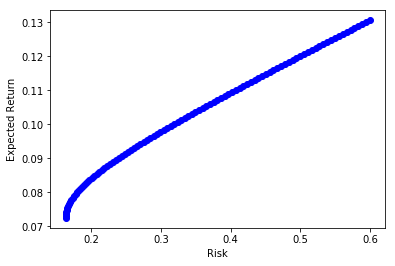

In [49]:
mu_vals = []
sig_vals = []

w1_vals = np.linspace(w_0[0], w_06[0], 100)
w2_vals = np.linspace(w_0[1], w_06[1], 100)
w3_vals = 1-w1_vals-w2_vals
w_vals =np.transpose(np.array([w1_vals, w2_vals, w3_vals]))

ones = np.ones(np.size(C, 0))
w_min = np.linalg.multi_dot([np.transpose(ones), np.linalg.inv(C)])/np.linalg.multi_dot([np.transpose(ones), 
                                                                                         np.linalg.inv(C), ones])
min_var = np.sqrt(np.linalg.multi_dot([w_min, C, np.transpose(w_min)]))
mu_cutoff = np.linalg.multi_dot([w_min, np.transpose(mu)])
print("The minimum portfolio variance possible is: " + str(min_var))

for i in range(np.size(w_vals, axis=0)):
    mu_vals.append(np.linalg.multi_dot([w_vals[i], np.transpose(mu)]))
    sig_vals.append(np.sqrt(np.linalg.multi_dot([w_vals[i], C, np.transpose(w_vals[i])])))
        
plt.plot(sig_vals_efficient, mu_vals_efficient, 'bo')
plt.plot(sig_vals_inefficient, mu_vals_inefficient, 'ro')
plt.xlabel("Risk")
plt.ylabel("Expected Return")
plt.show()

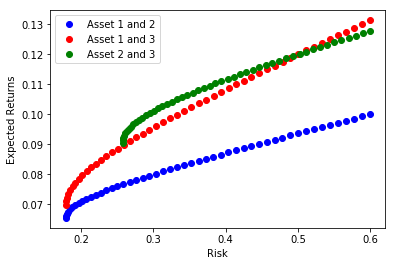

In [50]:
# Part b)
mu_12 = np.array([0.06, 0.08])
mu_13 = np.array([0.06, 0.12])
mu_23 = np.array([0.08, 0.12])
C_12 = np.array([[0.04, 0.01], [0.01, 0.09]])
C_13 = np.array([[0.04, -0.01], [-0.01, 0.25]])
C_23 = np.array([[0.09, 0], [0, 0.25]])

w0=[1/2, 1/2]
num_iter = 100000
tolerance = 0.0001
change = 0.0001

w_0_12 = find_w(target_sigma_0, w0, num_iter, tolerance, change, C_12)[0]
w_06_12 = find_w(target_sigma_0_6, w0, num_iter, tolerance, change, C_12)[0]
w1_vals_12 = np.linspace(w_0_12[0], w_06_12[0], 50)
w2_vals_12 = 1-w1_vals_12
w_vals_12 = np.transpose(np.array([w1_vals_12, w2_vals_12]))
muV_vals_12 = []
risk_vals_12 = []

w_0_13 = find_w(target_sigma_0, w0, num_iter, tolerance, change, C_13)[0]
w_06_13 = find_w(target_sigma_0_6, w0, num_iter, tolerance, change, C_13)[0]
w1_vals_13 = np.linspace(w_0_13[0], w_06_13[0], 50)
w2_vals_13 = 1-w1_vals_13
w_vals_13 = np.transpose(np.array([w1_vals_13, w2_vals_13]))
muV_vals_13 = []
risk_vals_13 = []

w_0_23 = find_w(target_sigma_0, w0, num_iter, tolerance, change, C_23)[0]
w_06_23 = find_w(target_sigma_0_6, w0, num_iter, tolerance, change, C_23)[0]
w1_vals_23 = np.linspace(w_0_23[0], w_06_23[0], 50)
w2_vals_23 = 1-w1_vals_23
w_vals_23 = np.transpose(np.array([w1_vals_23, w2_vals_23]))
muV_vals_23 = []
risk_vals_23 = []

for i in range(50):
    muV_vals_12.append(np.linalg.multi_dot([w_vals_12[i], np.transpose(mu_12)]))
    risk_vals_12.append(np.sqrt(np.linalg.multi_dot([w_vals_12[i], C_12, np.transpose(w_vals_12[i])])))
    
    muV_vals_13.append(np.linalg.multi_dot([w_vals_13[i], np.transpose(mu_13)]))
    risk_vals_13.append(np.sqrt(np.linalg.multi_dot([w_vals_13[i], C_13, np.transpose(w_vals_13[i])])))
    
    muV_vals_23.append(np.linalg.multi_dot([w_vals_23[i], np.transpose(mu_23)]))
    risk_vals_23.append(np.sqrt(np.linalg.multi_dot([w_vals_23[i], C_23, np.transpose(w_vals_23[i])])))
    
plt.plot(risk_vals_12, muV_vals_12, 'bo')
plt.plot(risk_vals_13, muV_vals_13, 'ro')
plt.plot(risk_vals_23, muV_vals_23, 'go')
plt.xlabel("Risk")
plt.ylabel("Expected Returns")
plt.legend(['Asset 1 and 2', 'Asset 1 and 3', 'Asset 2 and 3'])
plt.show()

In [51]:
ones = np.ones(np.size(C_12, 0))
w_min_12 = np.linalg.multi_dot([np.transpose(ones), np.linalg.inv(C_12)])/np.linalg.multi_dot([np.transpose(ones), 
                                                                                         np.linalg.inv(C_12), ones])
min_var_12 = np.sqrt(np.linalg.multi_dot([w_min_12, C_12, np.transpose(w_min_12)]))
muV_min_var_12 = np.linalg.multi_dot([w_min_12, np.transpose(mu_12)])

w_min_13 = np.linalg.multi_dot([np.transpose(ones), np.linalg.inv(C_13)])/np.linalg.multi_dot([np.transpose(ones), 
                                                                                         np.linalg.inv(C_13), ones])
min_var_13 = np.sqrt(np.linalg.multi_dot([w_min_13, C_13, np.transpose(w_min_13)]))
muV_min_var_13 = np.linalg.multi_dot([w_min_13, np.transpose(mu_13)])

w_min_23 = np.linalg.multi_dot([np.transpose(ones), np.linalg.inv(C_23)])/np.linalg.multi_dot([np.transpose(ones), 
                                                                                         np.linalg.inv(C_23), ones])
min_var_23 = np.sqrt(np.linalg.multi_dot([w_min_23, C_23, np.transpose(w_min_23)]))
muV_min_var_23 = np.linalg.multi_dot([w_min_23, np.transpose(mu_23)])

print("The minimum variance portfolio for the asset 1 and 2 combination has weights: " + str(w_min_12) + " with sigma and"
     " mu values of: " + str((min_var_12, muV_min_var_12)))
print("The minimum variance portfolio for the asset 1 and 3 combination has weights: " + str(w_min_13) + " with sigma and"
     " mu values of: " + str((min_var_13, muV_min_var_13)))
print("The minimum variance portfolio for the asset 2 and 3 combination has weights: " + str(w_min_23) + " with sigma and"
     " mu values of: " + str((min_var_23, muV_min_var_23)))

The minimum variance portfolio for the asset 1 and 2 combination has weights: [0.72727273 0.27272727] with sigma and mu values of: (0.17837651700316892, 0.06545454545454546)
The minimum variance portfolio for the asset 1 and 3 combination has weights: [0.83870968 0.16129032] with sigma and mu values of: (0.17870501915438117, 0.0696774193548387)
The minimum variance portfolio for the asset 2 and 3 combination has weights: [0.73529412 0.26470588] with sigma and mu values of: (0.25724787771376323, 0.09058823529411764)


### Part c)
> All the 4 curves start and end at the same risk value, but the expected returns are different. This is because, the different combinations of assets yields different portfolio weights at each $(\sigma, \mu)$ coordinate. This results in the curves having different slopes.